In [ ]:
# --- Import ---
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.models import vit_b_16, ViT_B_16_Weights
from torchvision import transforms
from datasets import load_dataset, Image
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
import numpy as np

In [ ]:
# --- Core building blocks (LayerNorm, GELU, FFN, causal MHA) ---
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

class GELU(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / math.pi, device=x.device, dtype=x.dtype)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        # causal mask
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, t, _ = x.shape
        q = self.W_query(x)
        k = self.W_key(x)
        v = self.W_value(x)
        q = q.view(b, t, self.num_heads, self.head_dim).transpose(1, 2)
        k = k.view(b, t, self.num_heads, self.head_dim).transpose(1, 2)
        v = v.view(b, t, self.num_heads, self.head_dim).transpose(1, 2)
        attn_scores = q @ k.transpose(2, 3)
        mask_bool = self.mask.bool()[:t, :t]
        attn_scores.masked_fill_(mask_bool, float('-inf'))
        attn_weights = torch.softmax(attn_scores / (self.head_dim ** 0.5), dim=-1)
        attn_weights = self.dropout(attn_weights)
        context_vec = (attn_weights @ v).transpose(1, 2).contiguous().view(b, t, self.d_out)
        return self.out_proj(context_vec)

In [ ]:
# --- Cross-attention block (no mask) ---
class Cross_MultiHead_Attention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, context):
        b, t_q, _ = x.shape
        t_ctx = context.shape[1]
        q = self.W_query(x)
        k = self.W_key(context)
        v = self.W_value(context)
        q = q.view(b, t_q, self.num_heads, self.head_dim).transpose(1, 2)
        k = k.view(b, t_ctx, self.num_heads, self.head_dim).transpose(1, 2)
        v = v.view(b, t_ctx, self.num_heads, self.head_dim).transpose(1, 2)
        attn_scores = q @ k.transpose(2, 3)
        attn_weights = torch.softmax(attn_scores / (self.head_dim ** 0.5), dim=-1)
        attn_weights = self.dropout(attn_weights)
        context_vec = (attn_weights @ v).transpose(1, 2).contiguous().view(b, t_q, self.d_out)
        return self.out_proj(context_vec)

class cross_attn_Block(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = Cross_MultiHead_Attention(
            d_in=cfg["emb_dim"], d_out=cfg["emb_dim"], context_length=cfg["context_length"],
            num_heads=cfg["n_heads"], dropout=cfg["drop_rate"], qkv_bias=cfg["qkv_bias"]
        )
        self.attn_norm = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x, context):
        shortcut = x
        x = self.attn_norm(x)
        x = self.att(x, context)
        x = self.drop_shortcut(x)
        return x + shortcut

In [ ]:
# --- Transformer block ---
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"], d_out=cfg["emb_dim"], context_length=cfg["context_length"],
            num_heads=cfg["n_heads"], dropout=cfg["drop_rate"], qkv_bias=cfg["qkv_bias"]
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        return x + shortcut

In [ ]:
# --- Vision encoder + Perceiver Resampler + VisionAdapter ---
class TorchvisionViTEncoder(nn.Module):
    def __init__(self, arch="vit_b_16", pretrained=True, freeze=True):
        super().__init__()
        if arch == "vit_b_16":
            weights = ViT_B_16_Weights.IMAGENET1K_V1 if pretrained else None
            base = vit_b_16(weights=weights)
        else:
            raise ValueError("Only vit_b_16 is implemented here.")
        self.model = base
        self.hidden_dim = base.hidden_dim
        if freeze:
            for p in self.parameters():
                p.requires_grad = False

    @torch.no_grad()
    def forward(self, images):
        features = self.model._process_input(images)  # (b, n, d)
        b, n, _ = features.shape
        cls_token = self.model.class_token.expand(b, -1, -1)
        x = torch.cat((cls_token, features), dim=1)
        x = self.model.encoder(x)
        patch_tokens = x[:, 1:, :]  # drop cls
        return patch_tokens

class PerceiverResampler(nn.Module):
    def __init__(self, dim, depth=2, num_latents=64, heads=8, dim_head=64, mlp_dim=256, dropout=0.0):
        super().__init__()
        self.latents = nn.Parameter(torch.randn(num_latents, dim))
        self.depth = depth
        self.heads = heads
        self.scale = (dim_head) ** -0.5
        self.to_q = nn.ModuleList([nn.Linear(dim, heads * dim_head, bias=False) for _ in range(depth)])
        self.to_kv = nn.ModuleList([nn.Linear(dim, heads * dim_head * 2, bias=False) for _ in range(depth)])
        self.proj_out = nn.ModuleList([nn.Linear(heads * dim_head, dim, bias=False) for _ in range(depth)])
        self.norms_latent = nn.ModuleList([nn.LayerNorm(dim) for _ in range(depth)])
        self.norms_media  = nn.ModuleList([nn.LayerNorm(dim) for _ in range(depth)])
        self.mlp = nn.ModuleList([
            nn.Sequential(nn.LayerNorm(dim), nn.Linear(dim, mlp_dim), nn.GELU(), nn.Linear(mlp_dim, dim), nn.Dropout(dropout))
            for _ in range(depth)
        ])
        self.dropout = nn.Dropout(dropout)

    def forward(self, media_seq):
        b, t, d = media_seq.shape
        x = self.latents.unsqueeze(0).expand(b, -1, -1)
        for i in range(self.depth):
            q = self.to_q[i](self.norms_latent[i](x))
            kv = self.to_kv[i](self.norms_media[i](media_seq))
            k, v = kv.chunk(2, dim=-1)
            h = self.heads
            dh = q.shape[-1] // h
            q = q.view(b, -1, h, dh).transpose(1, 2)
            k = k.view(b, -1, h, dh).transpose(1, 2)
            v = v.view(b, -1, h, dh).transpose(1, 2)
            attn = (q @ k.transpose(-2, -1)) * self.scale
            attn = attn.softmax(dim=-1)
            out = attn @ v
            out = out.transpose(1, 2).contiguous().view(b, -1, h * dh)
            out = self.proj_out[i](out)
            x = x + self.dropout(out)
            x = x + self.mlp[i](x)
        return x

class VisionProjector(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.proj = nn.Identity() if in_dim == out_dim else nn.Linear(in_dim, out_dim)
    def forward(self, x):
        return self.proj(x)

class VisionAdapter(nn.Module):
    def __init__(self, emb_dim, num_latents=64, perceiver_depth=2, perceiver_heads=8, perceiver_dim_head=64, dropout=0.0,
                encoder_type="torchvision_vit_b_16", pretrained=True, freeze=True):
        super().__init__()
        if encoder_type == "torchvision_vit_b_16":
            self.encoder = TorchvisionViTEncoder("vit_b_16", pretrained=pretrained, freeze=freeze)
            vision_dim = self.encoder.hidden_dim
            self.preprocess = ViT_B_16_Weights.IMAGENET1K_V1.transforms() if pretrained else None
        else:
            raise ValueError("Unsupported encoder_type")
        self.project = VisionProjector(vision_dim, emb_dim)
        self.resampler = PerceiverResampler(dim=emb_dim, depth=perceiver_depth, num_latents=num_latents,
                                            heads=perceiver_heads, dim_head=perceiver_dim_head, dropout=dropout)
    def forward(self, images):
        feats = self.encoder(images)
        feats = self.project(feats)
        visual_tokens = self.resampler(feats)
        return visual_tokens

In [ ]:
# --- GPTModal with optional vision injection at specified layers ---
class GPTModal(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        self.trf_blocks = nn.ModuleList([])
        for i in range(cfg["n_layers"]):
            if i in cfg["cross_attention_pos"]:
                self.trf_blocks.append(cross_attn_Block(cfg))
            self.trf_blocks.append(TransformerBlock(cfg))
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)
        self.vision_enabled = cfg.get("vision_enabled", True)
        if self.vision_enabled:
            self.vision = VisionAdapter(
                emb_dim=cfg["emb_dim"],
                num_latents=cfg.get("perceiver_num_latents", 64),
                perceiver_depth=cfg.get("perceiver_depth", 2),
                perceiver_heads=cfg.get("perceiver_heads", 8),
                perceiver_dim_head=cfg.get("perceiver_dim_head", 64),
                dropout=cfg.get("drop_rate", 0.0),
                encoder_type=cfg.get("vision_encoder_type", "torchvision_vit_b_16"),
                pretrained=cfg.get("vision_pretrained", True),
                freeze=cfg.get("vision_freeze", True)
            )
        else:
            self.vision = None

    def forward(self, in_idx, images=None):
      device = in_idx.device
      b, T = in_idx.shape
      pos = torch.arange(T, device=device, dtype=torch.long)
      tok = self.tok_emb(in_idx)                    # (B, T, D)
      pos_emb = self.pos_emb(pos).unsqueeze(0)      # (1, T, D) broadcast over batch
      x = tok + pos_emb
      x = self.drop_emb(x)

      visual_context = None
      if self.vision is not None and images is not None:
          images = images.to(device)
          visual_context = self.vision(images)      # (B, L, D)

      for layer in self.trf_blocks:
          if isinstance(layer, TransformerBlock):
              x = layer(x)
          elif isinstance(layer, cross_attn_Block) and visual_context is not None:
              x = layer(x, visual_context)

      x = self.final_norm(x)
      logits = self.out_head(x)
      return logits

In [ ]:
# --- Freeze utilities and parameter counting ---
def freeze_gpt_text_backbone(gpt, freeze_embeddings=True, freeze_transformer_blocks=True, freeze_final_ln=True, freeze_lm_head=True):
    if freeze_embeddings:
        for p in gpt.tok_emb.parameters(): p.requires_grad = False
        for p in gpt.pos_emb.parameters(): p.requires_grad = False
    if freeze_transformer_blocks:
        for blk in gpt.trf_blocks:
            if isinstance(blk, TransformerBlock):
                for p in blk.parameters():
                    p.requires_grad = False
    if freeze_final_ln:
        for p in gpt.final_norm.parameters(): p.requires_grad = False
    if freeze_lm_head:
        for p in gpt.out_head.parameters(): p.requires_grad = False

def count_trainable_params(model):
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total = sum(p.numel() for p in model.parameters())
    print(f"Trainable params: {trainable:,}")
    print(f"Total params:     {total:,}")
    return trainable, total

In [ ]:
#  --- Config and model instantiation ---
cfg = {
    "vocab_size": 50257,          # GPT-2
    "emb_dim": 768,               # GPT-2 small
    "context_length": 256,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": True,
    "cross_attention_pos": [2, 5, 8, 11],  # insert cross-attn before these TransformerBlocks

    "vision_enabled": True,
    "vision_encoder_type": "torchvision_vit_b_16",
    "vision_pretrained": True,
    "vision_freeze": True,

    "perceiver_num_latents": 64,
    "perceiver_depth": 2,
    "perceiver_heads": 8,
    "perceiver_dim_head": 64,

    "weight_decay": 0.01,
    "learning_rate": 1e-4,
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gpt = GPTModal(cfg).to(device)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:01<00:00, 197MB/s]


In [ ]:
# --- Model Loading ---

# 1. Fix vocabulary size mismatch
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({"pad_token": "<|pad|>"})

# Update config to match actual vocab size
cfg["vocab_size"] = len(tokenizer)

# 2. Recreate model with correct vocab size
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gpt = GPTModal(cfg).to(device)

# 3. Load GPT-2 weights with proper device handling
hf = GPT2LMHeadModel.from_pretrained("gpt2")
sd = hf.state_dict()
params = {k: v.cpu().numpy() for k, v in sd.items()}

# Copy original embeddings and add random initialization for new pad token
original_embeddings = torch.tensor(params['transformer.wte.weight'], device=device)
new_embeddings = torch.randn(cfg["vocab_size"], cfg["emb_dim"], device=device) * 0.02
new_embeddings[:original_embeddings.size(0)] = original_embeddings
gpt.tok_emb.weight = nn.Parameter(new_embeddings)

# Keep position embeddings as before - move to device
gpt.pos_emb.weight = nn.Parameter(torch.tensor(params['transformer.wpe.weight'], device=device))

# Load transformer blocks (unchanged from your original code but ensure device placement)
trf_only = [blk for blk in gpt.trf_blocks if isinstance(blk, TransformerBlock)]
for i, blk in enumerate(trf_only):
    w_qkv = params[f'transformer.h.{i}.attn.c_attn.weight']
    b_qkv = params[f'transformer.h.{i}.attn.c_attn.bias']
    q_w, k_w, v_w = np.split(w_qkv, 3, axis=-1)
    q_b, k_b, v_b = np.split(b_qkv, 3, axis=-1)

    blk.att.W_query.weight = nn.Parameter(torch.tensor(q_w.T, device=device))
    blk.att.W_key.weight   = nn.Parameter(torch.tensor(k_w.T, device=device))
    blk.att.W_value.weight = nn.Parameter(torch.tensor(v_w.T, device=device))
    blk.att.W_query.bias   = nn.Parameter(torch.tensor(q_b, device=device))
    blk.att.W_key.bias     = nn.Parameter(torch.tensor(k_b, device=device))
    blk.att.W_value.bias   = nn.Parameter(torch.tensor(v_b, device=device))

    blk.att.out_proj.weight = nn.Parameter(torch.tensor(params[f'transformer.h.{i}.attn.c_proj.weight'].T, device=device))
    blk.att.out_proj.bias   = nn.Parameter(torch.tensor(params[f'transformer.h.{i}.attn.c_proj.bias'], device=device))

    blk.ff.layers[0].weight = nn.Parameter(torch.tensor(params[f'transformer.h.{i}.mlp.c_fc.weight'].T, device=device))
    blk.ff.layers[0].bias   = nn.Parameter(torch.tensor(params[f'transformer.h.{i}.mlp.c_fc.bias'], device=device))
    blk.ff.layers[2].weight = nn.Parameter(torch.tensor(params[f'transformer.h.{i}.mlp.c_proj.weight'].T, device=device))
    blk.ff.layers[2].bias   = nn.Parameter(torch.tensor(params[f'transformer.h.{i}.mlp.c_proj.bias'], device=device))

    blk.norm1.scale = nn.Parameter(torch.tensor(params[f'transformer.h.{i}.ln_1.weight'], device=device))
    blk.norm1.shift = nn.Parameter(torch.tensor(params[f'transformer.h.{i}.ln_1.bias'], device=device))
    blk.norm2.scale = nn.Parameter(torch.tensor(params[f'transformer.h.{i}.ln_2.weight'], device=device))
    blk.norm2.shift = nn.Parameter(torch.tensor(params[f'transformer.h.{i}.ln_2.bias'], device=device))

# Load final layer norm - move to device
gpt.final_norm.scale = nn.Parameter(torch.tensor(params['transformer.ln_f.weight'], device=device))
gpt.final_norm.shift = nn.Parameter(torch.tensor(params['transformer.ln_f.bias'], device=device))

# Tie embeddings (use the new expanded embedding matrix)
gpt.out_head.weight = gpt.tok_emb.weight

print(f"Model successfully loaded on {device}")
print(f"Vocab size: {cfg['vocab_size']}")
print(f"Embedding matrix device: {gpt.tok_emb.weight.device}")
print(f"Position embedding device: {gpt.pos_emb.weight.device}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Model successfully loaded on cuda
Vocab size: 50258
Embedding matrix device: cuda:0
Position embedding device: cuda:0


In [ ]:
#v --- Fixed Dataset, DataLoader, and Image Preprocessing ---

# One shard from the dataset
parquet_url = "hf://datasets/yhshin1020/coco-img-caption-pairs@main/data/train-00000-of-00003.parquet"
hf_ds = load_dataset("parquet", data_files=parquet_url, split="train")
hf_ds = hf_ds.cast_column("image", Image())  # PIL decode

# ViT-B/16 transforms with proper grayscale handling
image_tx = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda x: x.convert('RGB')),  # Convert grayscale to RGB
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# GPT-2 tokenizer with pad token - HANDLE VOCAB SIZE MISMATCH
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({"pad_token": "<|pad|>"})

# After adding tokens, ensure embedding matrices match tokenizer size
new_vocab_size = len(tokenizer)
if new_vocab_size != gpt.tok_emb.num_embeddings:
    print(f"Resizing embeddings: {gpt.tok_emb.num_embeddings} -> {new_vocab_size}")
    old_weight = gpt.tok_emb.weight.data
    old_vocab_size, emb_dim = old_weight.shape
    new_weight = torch.empty(new_vocab_size, emb_dim, device=old_weight.device, dtype=old_weight.dtype)
    new_weight[:old_vocab_size] = old_weight
    nn.init.normal_(new_weight[old_vocab_size:], mean=0.0, std=0.02)
    gpt.tok_emb.weight = nn.Parameter(new_weight)
    # Re-tie LM head by reference after resize
    gpt.out_head.weight = gpt.tok_emb.weight
    cfg["vocab_size"] = new_vocab_size  # keep config in sync

# Special token ids and pad id
bos_id = tokenizer.bos_token_id
eos_id = tokenizer.eos_token_id
if bos_id is None:
    bos_id = eos_id  # fallback
assert bos_id is not None and eos_id is not None, "Tokenizer must have BOS/EOS"
assert bos_id < len(tokenizer) and eos_id < len(tokenizer), "Special IDs out of range"

pad_id = tokenizer.pad_token_id
assert pad_id is not None and pad_id < len(tokenizer), "Pad token must be set and in range"

class CocoParquetDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, tokenizer, context_length, image_transform):
        self.ds = hf_dataset
        self.tok = tokenizer
        self.ctx = context_length
        self.image_tx = image_transform

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        try:
            ex = self.ds[idx]
            pil = ex["image"]         # PIL.Image.Image
            cap = ex["caption"]       # string

            # Handle potential image loading issues
            if pil is None or pil.size == (0, 0):
                # Return a dummy black image if there's an issue
                pil = Image.new('RGB', (224, 224), color='black')

            img_t = self.image_tx(pil)

            # Encode caption with BOS ... EOS and truncate to context
            ids = [bos_id] + self.tok.encode(cap, add_special_tokens=False) + [eos_id]
            ids = ids[:self.ctx]

            return {
                "input_ids": torch.tensor(ids, dtype=torch.long),
                "image": img_t
            }
        except Exception as e:
            print(f"Error processing sample {idx}: {e}")
            # Return a fallback sample
            dummy_img = torch.zeros(3, 224, 224)  # RGB dummy image
            dummy_ids = [bos_id, eos_id]
            return {
                "input_ids": torch.tensor(dummy_ids, dtype=torch.long),
                "image": dummy_img
            }

def collate_fn(batch, pad_id=0, ctx=256, vocab_size=None):
    imgs = torch.stack([b["image"] for b in batch], dim=0)
    seqs = [b["input_ids"] for b in batch]

    def pad_to_ctx(seq):
        if seq.numel() >= ctx:
            s = seq[:ctx]
        else:
            s = torch.cat([seq, torch.full((ctx - seq.numel(),), pad_id, dtype=seq.dtype)], dim=0)
        if vocab_size is not None:
            s = torch.clamp(s, 0, vocab_size - 1)  # safety against out-of-range ids
        return s

    input_ids = torch.stack([pad_to_ctx(s) for s in seqs], dim=0)
    # Build labels as next-token targets; ignore padding in loss
    labels = input_ids.clone()
    labels[:, :-1] = input_ids[:, 1:]
    labels[:, -1] = pad_id
    labels[labels == pad_id] = -100
    return {"input_ids": input_ids, "labels": labels, "images": imgs}

context_length = cfg["context_length"]
train_ds = CocoParquetDataset(hf_ds, tokenizer, context_length, image_tx)
train_loader = DataLoader(
    train_ds,
    batch_size=16,
    shuffle=True,
    num_workers=0,
    pin_memory=True,
    collate_fn=lambda b: collate_fn(b, pad_id=pad_id, ctx=context_length, vocab_size=len(tokenizer))
)

# Re-apply freezing after embedding resize
freeze_gpt_text_backbone(gpt, freeze_embeddings=True, freeze_transformer_blocks=True,
                        freeze_final_ln=True, freeze_lm_head=True)

print("Dataset and DataLoader created successfully")
print(f"Dataset size: {len(train_ds)}")
print(f"Number of batches: {len(train_loader)}")

data/train-00000-of-00003.parquet:   0%|          | 0.00/44.3M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset and DataLoader created successfully
Dataset size: 1707
Number of batches: 107


In [ ]:
# --- Recreate optimizer for updated parameters ---
optimizer = torch.optim.AdamW(
    (p for p in gpt.parameters() if p.requires_grad),
    lr=cfg["learning_rate"],
    weight_decay=cfg["weight_decay"],
    betas=(0.9, 0.999),
    eps=1e-8
)

print(f"Final vocab_size: {cfg['vocab_size']}")
print(f"Pad token ID: {pad_id}")
print(f"Model embedding size: {gpt.tok_emb.num_embeddings}")
count_trainable_params(gpt)

# Training functions (unchanged)
loss_fn = nn.CrossEntropyLoss(ignore_index=-100)

def train_one_epoch(model, dataloader, optimizer, device, grad_accum_steps=1):
    model.train()
    running = 0.0
    pbar = tqdm(dataloader, leave=False, dynamic_ncols=True)
    optimizer.zero_grad(set_to_none=True)
    for i, batch in enumerate(pbar):
        input_ids = batch["input_ids"].to(device)
        labels = batch["labels"].to(device)
        images = batch["images"].to(device)
        logits = model(input_ids, images=images)
        loss = loss_fn(logits.view(-1, logits.size(-1)), labels.view(-1))
        (loss / grad_accum_steps).backward()
        if (i + 1) % grad_accum_steps == 0:
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)
        running += loss.item()
        pbar.set_description(f"loss {running / (i+1):.4f}")
    return running / max(1, len(dataloader))

@torch.no_grad()
def evaluate(model, dataloader, device):
    model.eval()
    total, n = 0.0, 0
    pbar = tqdm(dataloader, leave=False, dynamic_ncols=True)
    for batch in pbar:
        input_ids = batch["input_ids"].to(device)
        labels = batch["labels"].to(device)
        images = batch["images"].to(device)
        logits = model(input_ids, images=images)
        loss = loss_fn(logits.view(-1, logits.size(-1)), labels.view(-1))
        total += loss.item()
        n += 1
        pbar.set_description(f"val {total / n:.4f}")
    return total / max(1, n)

def fit(model, train_loader, optimizer, device, epochs=1):
    for ep in range(epochs):
        train_loss = train_one_epoch(model, train_loader, optimizer, device)
        print(f"Epoch {ep+1}: train {train_loss:.4f}")

Final vocab_size: 50258
Pad token ID: 50257
Model embedding size: 50258
Trainable params: 13,448,192
Total params:     224,456,424


In [ ]:
# --- Train a bit (optional demo run) ---
fit(gpt, train_loader, optimizer, device, epochs=25)

  0%|          | 0/107 [00:00<?, ?it/s]

Epoch 1: train 8.2270


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch 2: train 3.6556


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch 3: train 3.4650


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch 4: train 3.3716


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch 5: train 3.2118


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch 6: train 3.1188


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch 7: train 3.0196


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch 8: train 2.9143


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch 9: train 2.8113


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch 10: train 2.7034


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch 11: train 2.6182


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch 12: train 2.5246


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch 13: train 2.4189


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch 14: train 2.3195


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch 15: train 2.2266


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch 16: train 2.1317


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch 17: train 2.0442


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch 18: train 1.9644


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch 19: train 1.8892


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch 20: train 1.7982


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch 21: train 1.7529


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch 22: train 1.6662


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch 23: train 1.5917


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch 24: train 1.5383


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch 25: train 1.4746


In [ ]:
# --- Inference utilities (sampling + display) ---
def top_k_top_p_filtering(logits, top_k=0, top_p=1.0):
    if top_k > 0:
        values, _ = torch.topk(logits, min(top_k, logits.size(-1)))
        min_values = values[..., -1, None]
        logits = torch.where(logits < min_values, torch.full_like(logits, float('-inf')), logits)
    if top_p < 1.0:
        sorted_logits, sorted_indices = torch.sort(logits, descending=True)
        cumulative_probs = torch.softmax(sorted_logits, dim=-1).cumsum(dim=-1)
        sorted_mask = cumulative_probs > top_p
        sorted_mask[..., 1:] = sorted_mask[..., :-1].clone()
        sorted_mask[..., 0] = False
        logits = logits.scatter(1, sorted_indices, sorted_logits.masked_fill(sorted_mask, float('-inf')))
    return logits

@torch.no_grad()
def generate_caption(model, tokenizer, pil_image, max_new_tokens=32, temperature=0.9, top_p=0.9, top_k=50, eos_token_id=None, device=None):
    model.eval()
    device = device or next(model.parameters()).device
    # preprocess image
    image_tx = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img_t = image_tx(pil_image).unsqueeze(0).to(device)
    # prompt: empty BOS
    bos_id = tokenizer.bos_token_id if tokenizer.bos_token_id is not None else tokenizer.eos_token_id
    eos_id = eos_token_id if eos_token_id is not None else tokenizer.eos_token_id
    input_ids = torch.tensor([[bos_id]], dtype=torch.long, device=device)
    for _ in range(max_new_tokens):
        logits = model(input_ids, images=img_t)[:, -1, :]
        logits = logits / max(1e-8, temperature)
        logits = top_k_top_p_filtering(logits, top_k=top_k, top_p=top_p)
        probs = F.softmax(logits, dim=-1)
        next_id = torch.multinomial(probs, num_samples=1)
        input_ids = torch.cat([input_ids, next_id], dim=1)
        if eos_id is not None and next_id.item() == eos_id:
            break
    text = tokenizer.decode(input_ids[0].tolist(), skip_special_tokens=True).strip()
    return text

def show_image_and_text(pil_image, text):
    plt.figure(figsize=(3, 3))
    plt.imshow(pil_image)
    plt.axis("off")
    plt.title("Input image")
    plt.show()
    print("Text generated from model:")
    print(text)

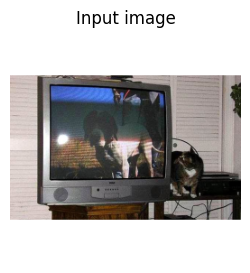

Text generated from model:
A cat that is sitting on top of a dog on a table.


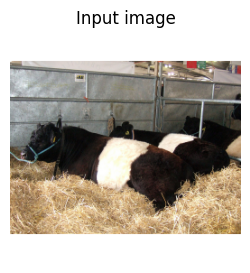

Text generated from model:
A group of cows are laying in hay.


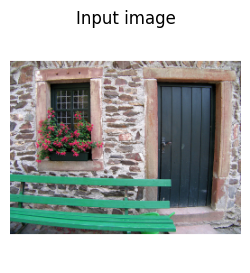

Text generated from model:
A green and white bench in front of a house.


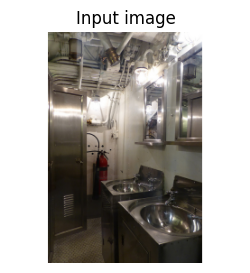

Text generated from model:
A metal sink with mirrors is shown above the mirrors.


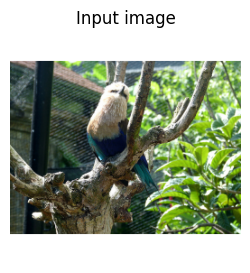

Text generated from model:
A bird on a tree limb.


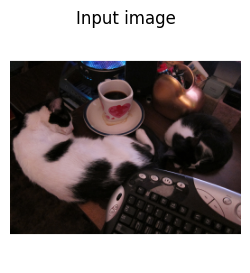

Text generated from model:
A cat laying on a bed next to a keyboard.


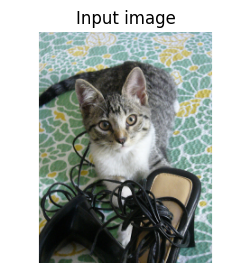

Text generated from model:
A cat standing on a bed with a pair of shoes on it.


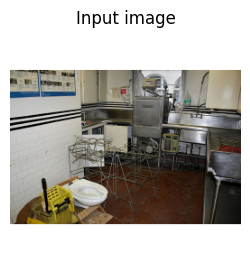

Text generated from model:
A toilet, sink, and toilet in a industrial toilet.


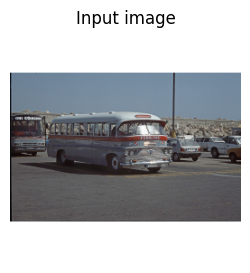

Text generated from model:
A silver and blue bus in a parking lot.


In [ ]:
# --- Test on a dataset image  ---
# Grab a sample from the same HF dataset
for i in range(1,10):
  idx = np.random.randint(0, len(hf_ds))
  sample = hf_ds[idx]
  pil_image = sample["image"]  # PIL.Image
  gen_text = generate_caption(
      model=gpt,
      tokenizer=tokenizer,
      pil_image=pil_image,
      max_new_tokens=48,
      temperature=0.7,
  )
  show_image_and_text(pil_image, gen_text)

In [ ]:
# --- Model saving functions ---
def save_model_checkpoint(model, tokenizer, cfg, save_path, epoch=None, loss=None):
    """
    Save complete model checkpoint with all necessary components
    """
    import os
    os.makedirs(save_path, exist_ok=True)

    checkpoint = {
        'model_state_dict': model.state_dict(),
        'config': cfg,
        'epoch': epoch,
        'loss': loss,
        'model_class': 'GPTModal',  # For reconstruction
    }

    # Save model checkpoint
    model_path = os.path.join(save_path, 'model_checkpoint.pth')
    torch.save(checkpoint, model_path)

    # Save tokenizer
    tokenizer_path = os.path.join(save_path, 'tokenizer')
    tokenizer.save_pretrained(tokenizer_path)

    # Save config as JSON for easy reading
    import json
    config_path = os.path.join(save_path, 'config.json')
    with open(config_path, 'w') as f:
        json.dump(cfg, f, indent=2)

    print(f"Model saved to: {save_path}")
    print(f"Files saved:")
    print(f"  - {model_path}")
    print(f"  - {tokenizer_path}/")
    print(f"  - {config_path}")

def load_model_checkpoint(save_path, device=None):
    """
    Load complete model checkpoint
    """
    import os
    import json

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load config
    config_path = os.path.join(save_path, 'config.json')
    with open(config_path, 'r') as f:
        cfg = json.load(f)

    # Load tokenizer
    tokenizer_path = os.path.join(save_path, 'tokenizer')
    tokenizer = GPT2TokenizerFast.from_pretrained(tokenizer_path)

    # Recreate model
    model = GPTModal(cfg).to(device)

    # Load model weights
    model_path = os.path.join(save_path, 'model_checkpoint.pth')
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])

    print(f"Model loaded from: {save_path}")
    print(f"Epoch: {checkpoint.get('epoch', 'Unknown')}")
    print(f"Loss: {checkpoint.get('loss', 'Unknown')}")

    return model, tokenizer, cfg


# 2. Save the model
save_path = "./vision_gpt_model"
save_model_checkpoint(gpt, tokenizer, cfg, save_path, epoch=1, loss=None)

# 3. Example of loading the model later (don't run this now, just for reference)
# loaded_model, loaded_tokenizer, loaded_cfg = load_model_checkpoint("./vision_gpt_model")

print("\nModel training and saving complete!")

Model saved to: ./vision_gpt_model
Files saved:
  - ./vision_gpt_model/model_checkpoint.pth
  - ./vision_gpt_model/tokenizer/
  - ./vision_gpt_model/config.json

Model training and saving complete!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# copy the saved model folder to drive
import os
save_path = "./vision_gpt_model"
drive_path = "/content/drive/MyDrive/vision_gpt_model"

# Create the target directory in Drive if it doesn't exist
if not os.path.exists(drive_path):
    os.makedirs(drive_path)

# Copy the contents
!cp -r {save_path}/* {drive_path}/

print(f"Copied model from {save_path} to {drive_path}")

Copied model from ./vision_gpt_model to /content/drive/MyDrive/vision_gpt_model


Testing image influence on generation...


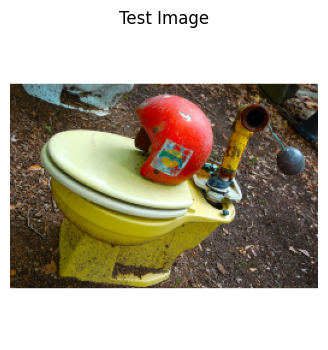

=== GENERATION WITH IMAGE ===
Sample 1: A yellow toilet with a colorful backpack next to it.
Sample 2: A red toilet sitting in a dirt pit with a backpack in the dirt.
Sample 3: A yellow toilet sitting on a dirt floor with a helmet on top.

=== GENERATION WITHOUT IMAGE ===
Sample 1: it
Sample 2: " " " " " "
Sample 3: " " " " " "

=== ANALYSIS ===
✓ Image DOES influence generation (outputs differ)

Model has 4 cross-attention layers
Cross-attention positions: [2, 5, 8, 11]
✓ Vision adapter is present
Vision adapter trainable params: 3,992,576


In [ ]:
# Test to verify image influence on text generation
def test_image_influence(model, tokenizer, pil_image, max_new_tokens=32, temperature=0.7):
    """
    Generate captions with and without image to see if image actually influences output
    """
    model.eval()
    device = next(model.parameters()).device

    # Preprocess image
    image_tx = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Lambda(lambda x: x.convert('RGB')),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img_t = image_tx(pil_image).unsqueeze(0).to(device)

    bos_id = tokenizer.bos_token_id if tokenizer.bos_token_id is not None else tokenizer.eos_token_id
    eos_id = tokenizer.eos_token_id

    @torch.no_grad()
    def generate_with_image():
        input_ids = torch.tensor([[bos_id]], dtype=torch.long, device=device)
        for _ in range(max_new_tokens):
            # WITH image
            logits = model(input_ids, images=img_t)[:, -1, :]
            logits = logits / max(1e-8, temperature)
            probs = F.softmax(logits, dim=-1)
            next_id = torch.multinomial(probs, num_samples=1)
            input_ids = torch.cat([input_ids, next_id], dim=1)
            if eos_id is not None and next_id.item() == eos_id:
                break
        return tokenizer.decode(input_ids[0].tolist(), skip_special_tokens=True).strip()

    @torch.no_grad()
    def generate_without_image():
        input_ids = torch.tensor([[bos_id]], dtype=torch.long, device=device)
        for _ in range(max_new_tokens):
            # WITHOUT image (pass None)
            logits = model(input_ids, images=None)[:, -1, :]
            logits = logits / max(1e-8, temperature)
            probs = F.softmax(logits, dim=-1)
            next_id = torch.multinomial(probs, num_samples=1)
            input_ids = torch.cat([input_ids, next_id], dim=1)
            if eos_id is not None and next_id.item() == eos_id:
                break
        return tokenizer.decode(input_ids[0].tolist(), skip_special_tokens=True).strip()

    # Generate multiple samples to see consistency
    print("=== GENERATION WITH IMAGE ===")
    with_image_texts = []
    for i in range(3):
        text = generate_with_image()
        with_image_texts.append(text)
        print(f"Sample {i+1}: {text}")

    print("\n=== GENERATION WITHOUT IMAGE ===")
    without_image_texts = []
    for i in range(3):
        text = generate_without_image()
        without_image_texts.append(text)
        print(f"Sample {i+1}: {text}")

    # Analyze differences
    print("\n=== ANALYSIS ===")
    if with_image_texts != without_image_texts:
        print("✓ Image DOES influence generation (outputs differ)")
        return True
    else:
        print("✗ Image does NOT influence generation (outputs identical)")
        return False

# Test with a sample image
idx = np.random.randint(0, len(hf_ds))
sample = hf_ds[idx]
pil_image = sample["image"]

print("Testing image influence on generation...")
plt.figure(figsize=(4, 4))
plt.imshow(pil_image)
plt.axis('off')
plt.title("Test Image")
plt.show()

has_image_influence = test_image_influence(gpt, tokenizer, pil_image)

# Additional diagnostic: Check cross-attention weights
def inspect_cross_attention_usage(model):
    """Check if cross-attention layers are being used"""
    cross_attn_layers = [layer for layer in model.trf_blocks if isinstance(layer, cross_attn_Block)]
    print(f"\nModel has {len(cross_attn_layers)} cross-attention layers")
    print(f"Cross-attention positions: {model.cfg['cross_attention_pos']}")

    # Check if vision adapter is properly loaded
    if hasattr(model, 'vision') and model.vision is not None:
        print("✓ Vision adapter is present")
        print(f"Vision adapter trainable params: {sum(p.numel() for p in model.vision.parameters() if p.requires_grad):,}")
    else:
        print("✗ Vision adapter missing or None")

inspect_cross_attention_usage(gpt)